In [14]:
import time

import os
import pandas as pd
import pysam
import anndata as ad
import re
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

PROJECT_PATH = '/home/fichtner/projects/gemmo-tools'
DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# DATA_PATH_ALT = '/home/fichtner/data/datasets/hca-brain-organoids_small'
SAMPLES = [f for f in os.listdir(DATA_PATH + 'outputs') if os.path.isdir(os.path.join(DATA_PATH + 'outputs', f))]
# SAMPLES = ['sSL0146_BrainO_R4_F_10xM_Multiome', 'sSL0136_BrainO_R3_B_10xM_Multiome', 'sSL0170_BrainO_R4_F_10xM_Multiome']
RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'
# OUT_FILE = 'CD14_filtered_fragments_10k.tsv'

os.chdir(PROJECT_PATH)

## TODOs
- [ ] Check if QC works. Huge difference filtered vs unfiltered cells in script: 362 vs 2344

## Helper functions

In [2]:
def regex_get(text, pattern=None):
    
    pattern_map = {'sample_name': r'sSL\d*',
                   'barcode': r'^\D*-\d*'}

    if pattern in pattern_map.keys():
        pattern = pattern_map[pattern]
    
    match = re.search(pattern, text)
    return match.group()


def create_profile(frags, region_name, region_start, region_end):

    frags = frags.copy()
    cell_idx = np.linspace(0, len(frags) - 1, len(frags), dtype=int)
    # print(f'{region_name}\tstart: {region_start}\tend: {region_end}\tdiff: {region_end - region_start + 1}')
    # print(f'Min start: {min(frags["start"]) - region_start + 1}\nMin end: {min(frags["end"]) - region_start + 1}')
    
    if min(frags['start']) - region_start >= 0:
        # print('AHHH!')
        frags['start_0'] = frags['start'] - region_start
        frags['end_0'] = frags['end'] - region_start
        
        insertions = np.ones(len(frags)*2)
        row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
        # print(max(row_indices))
        # print(len(row_indices))
        col_indices = np.concatenate([cell_idx, cell_idx])
        
        profile_sm = csr_matrix((insertions, (row_indices, col_indices)),
                                shape = [max(row_indices) + 1 if max(row_indices) >= (region_end - region_start) else (region_end - region_start) + 1,
                                         len(frags)])
        # print(profile_sm.get_shape())
        profile_sm = profile_sm[0: region_end - region_start + 1]
        # print(profile_sm.get_shape())

    else:

        # print('---')
        frags['start_0'] = frags['start'] - min(frags['start'])
        frags['end_0'] = frags['end'] - min(frags['start'])

        insertions = np.ones(len(frags)*2)
        row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
        col_indices = np.concatenate([cell_idx, cell_idx])
        # print(f'max row_indices: {max(row_indices)}')
        # print(f'min row_indices: {min(row_indices)}')
        # print(f'len row_indices: {len(row_indices)}')
        profile_sm = csr_matrix((insertions, (row_indices, col_indices)),
                                shape = [max(row_indices) + 1 if max(row_indices) > (region_end - min(frags['start'])) else (region_end - min(frags['start']) + 1) + 1,
                                         len(frags)])
        # print(profile_sm.get_shape())
        profile_sm = profile_sm[region_start - min(frags['start']) : region_end - min(frags['start']) + 1]
        # print(profile_sm.get_shape())    

    profile = profile_sm.sum(axis=1).tolist()
    profile = [j for i in profile for j in i]
    # print('{}:\tLen: {}\tCounts: {}'.format(region_name, len(profile), sum(profile)))

    return profile, len(frags)

## Get metadata

In [3]:
borgs_rna = ad.read_h5ad(DATA_PATH + RNA_AD, backed='r')

In [4]:
# Metadata of cells that passed QC
cells_coldata = borgs_rna.obs[['sample', 'donor', 'donor_id', 'celltype_predicted_vertesy']].copy()
cells_coldata.rename(columns={'celltype_predicted_vertesy': 'cell_type'}, inplace=True)
cells_coldata['barcode'] = [regex_get(i, 'barcode') for i in cells_coldata.index.tolist()]

qc_cells = cells_coldata.index.tolist()

cell_types = tuple(set(cells_coldata['cell_type']))
cell_types = sorted(cell_types, key=str.upper)

samples = tuple(set(cells_coldata['sample']))
samples = sorted(samples, key=str.upper)

donors = tuple(set(cells_coldata['donor']))
donors = sorted(donors, key=str.upper)

# groups = donors
groups = ['bima']

# Note: (indexes ~ cell id) = barcode_sample --> are unique but barcodes aren't

## Parse and create profiles

In [5]:
regions = {
    'CYC1': ['chr8', 144095039 - 5000, 144095039 + 5000 ], # Cytochrome C1 (+) chr8:144,095,039-144,097,525
    'RPL13': [ 'chr8', 120445402 - 5000, 120445402 + 5000], # Mitochondrial Ribosomal Protein L13 (-) chr8:120,380,761-120,445,402
    'MEF2C': ['chr5', 88904257 - 5000, 88904257 + 5000], # (-) chr5:88717117-88904257 1-based
    'SOX2': ['chr3', 181711925 - 5000, 181711925 + 5000], # (+) chr3:181,711,925-181,714,436 
    'LHX5': ['chr12', 113472280 - 5000, 113472280 + 5000] # (-) chr12:113,462,033-113,472,280
}

In [6]:
min_frag_size = 10
max_frag_size = 200

In [8]:
st = time.time()

# if os.path.exists(OUT_FILE):
#     print('Output file already exists')
#     os.remove(OUT_FILE)


profiles = {}


for r in regions.keys():
    
    frags = pd.DataFrame(columns=['chr', 'start', 'end', 'barcode', 'counts', 'sample', 'donor', 'donor_id', 'cell_type'])

    for s in SAMPLES:

        sample_path = os.path.join(DATA_PATH, 'outputs', s, s, 'outs/atac_fragments.tsv.gz')
        #sample_path = os.path.join(DATA_PATH_ALT, 'outputs', s, s, 'outs/atac_fragments.tsv.gz')
        sample_name = regex_get(s, 'sample_name')

        tbx = pysam.TabixFile(sample_path, parser=pysam.asTuple())

        for row in tbx.fetch(*regions[r]):

            cell_id = '{}_{}'.format(row[3], sample_name)


            if cell_id in qc_cells:# and (int(row[2]) - int(row[1])) > min_frag_size and (int(row[2]) - int(row[1])) < max_frag_size:

                entry = {'chr': row[0],
                          'start': int(row[1]) + 1, # Make 1-based
                          'end': int(row[2]), # End inclusive
                          'barcode': row[3],
                          'counts': row[4],
                          'sample': cells_coldata.loc[cell_id, 'sample'],
                          'donor': cells_coldata.loc[cell_id, 'donor'],
                          'donor_id': cells_coldata.loc[cell_id, 'donor_id'], 
                          'cell_type': cells_coldata.loc[cell_id, 'cell_type']}

                frags = frags._append(entry, ignore_index=True)

    profiles[r] = frags

et = time.time()
print(et - st)


for r in profiles.keys():
    
    print('{}:\tn_frags={}'.format(r, len(profiles[r])))
          
# MEF2C promoter: 1 sample --> 2s
# MEF2C promoter: 3 samples --> 5s
# MEF2C promoter: All samples --> 204s
# MEF2C promoter: All samples --> 204s
# MEF2C, SOX2, LHX5 promoters: 3 samples --> 50
# MEF2C, SOX2, LHX5 promoters: All samples --> 2674s
# MEF2C, SOX2, LHX5, CYC1, RPL13: All samples --> 4007-6828s

6827.694661855698
CYC1:	n_frags=68083
RPL13:	n_frags=21999
MEF2C:	n_frags=730
SOX2:	n_frags=80523
LHX5:	n_frags=28249


In [11]:
# Init dict
profiles_subset = {}

for r in regions:
    
    profiles_subset[r] = {}
    
    for d in donors:
        
        profiles_subset[r][d] = {}
        
        for ct in cell_types:
            
            profiles_subset[r][d][ct] = {}
            


for r in regions:

    for d in donors:

        for ct in cell_types:

            subset = (profiles[r]['donor'] == d) & (profiles[r]['cell_type'] == ct)
            
            if sum(subset) > 0:
                profiles_subset[r][d][ct]['profile'], profiles_subset[r][d][ct]['n_cells'] = create_profile(profiles[r][subset], *regions[r])
            else:
                profiles_subset[r][d][ct] = None

In [12]:
# How many Nones?
n_nones = sum([(profiles_subset[r][d][ct] == None) for r in profiles_subset.keys() for d in donors for ct in cell_types])
total_groups = sum([True for r in profiles_subset.keys() for d in donors for ct in cell_types])
print('Fraction of donor-cell_type groups without any fragments: {}'.format(round(n_nones / (total_groups), 2)))

Fraction of donor-cell_type groups without any fragments: 0.37


In [13]:
# CT and donors to plot

q_ct = ['Glia', 'UL-EN', 'Midbrain EN']
q_donors = ['pelm', 'zoxy']

subset = cells_coldata[cells_coldata['donor'].isin(q_donors)].copy()
subset['donor'] = subset['donor'].astype(str)
subset.groupby(['donor', 'cell_type']).size().reset_index(name='n_cells')

,donor,cell_type,n_cells
0,pelm,DL-EN,90
1,pelm,Differentiating RG,38
2,pelm,Dividing Glia,307
3,pelm,Glia,489
4,pelm,IPC,143
5,pelm,Interneurons,210
6,pelm,Interneurons Prog.,296
7,pelm,Midbrain EN,825
8,pelm,Stressed Neurons,185
9,pelm,Stressed Prog.,544


In [34]:
data.dtypes

donor        object
cell_type    object
n_cells       int64
group        object
dtype: object

Text(0.5, 0, '')

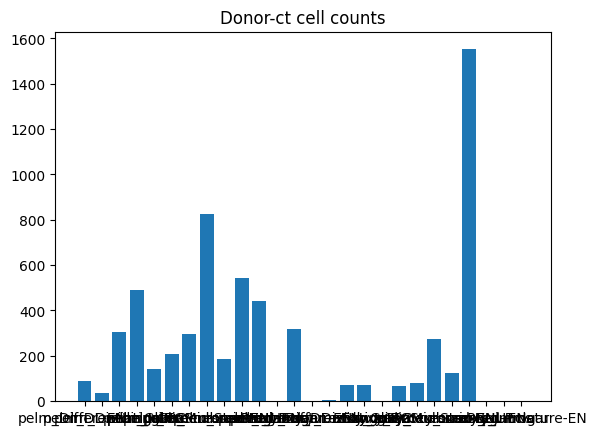

In [37]:
data = subset.groupby(['donor', 'cell_type']).size().reset_index(name='n_cells')
data['donor'] = data ['donor'].astype(str)
data['cell_type'] = data ['cell_type'].astype(str)
data['group'] = data['donor'] + '_' + data['cell_type']
data['group'] = data['group'].apply(lambda x: x.replace(' ', '-').replace('.', ''))


plt.bar(data['group'], data['n_cells'])

# # Add a title and labels
plt.title('Donor-ct cell counts')
plt.xlabel('')

# Show the plot
plt.show()

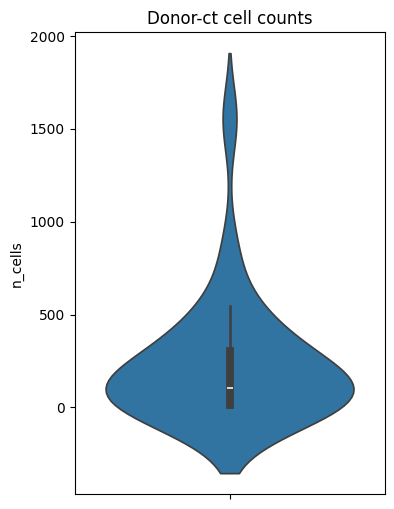

In [22]:
data = subset.groupby(['donor', 'cell_type']).size().reset_index(name='n_cells')['n_cells']
plt.figure(figsize=(4, 6))

sns.violinplot(data=data['n_cells'])

# Add a title and labels
plt.title('Donor-ct cell counts')
plt.xlabel('')

# Show the plot
plt.show()

In [ ]:
for r in profiles_subset.keys():
    
    for d in q_donors:
        
        for ct in q_ct:
    
            if profiles_subset[r][d][ct]:
                print(f'{r} - {d} - {ct}\tLen: {len(profiles_subset[r][d][ct]["profile"])}\tCounts: {int(sum(profiles_subset[r][d][ct]["profile"]))}\tn_cells: {profiles_subset[r][d][ct]["n_cells"]}') 
                plt.bar(np.linspace(1, len(profiles_subset[r][d][ct]['profile']), len(profiles_subset[r][d][ct]['profile'])), profiles_subset[r][d][ct]['profile'])
                plt.xlim([4750,5250])
                plt.ylim([1,60])
                plt.show()
            else:
                print(f'Region: {r}, donor: {d}, cell type: {ct} --> No fragments found')

In [19]:
# How many Nones?
n_nones = sum([(profiles_subset[r][d][ct] == None) for r in profiles_subset.keys() for d in donors for ct in cell_types])
total_groups = sum([True for r in profiles_subset.keys() for d in donors for ct in cell_types])
print('Fraction of donor-cell_type groups without any fragments: {}'.format(round(n_nones / (total_groups), 2)))

Fraction of donor-cell_type groups without any fragments: 0.37


In [61]:
# CT and donors to plot

q_ct = ['Glia', 'UL-EN']
q_donors = ['melw', 'pelm', 'ualw', 'zoxy']

subset = cells_coldata[cells_coldata['donor'].isin(q_donors)].copy()
subset['donor'] = subset['donor'].astype(str)
subset.groupby(['donor', 'cell_type']).size().reset_index(name='n_cells')

,donor,cell_type,n_cells
0,pelm,DL-EN,90
1,pelm,Differentiating RG,38
2,pelm,Dividing Glia,307
3,pelm,Glia,489
4,pelm,IPC,143
5,pelm,Interneurons,210
6,pelm,Interneurons Prog.,296
7,pelm,Midbrain EN,825
8,pelm,Stressed Neurons,185
9,pelm,Stressed Prog.,544


CYC1 - pelm - Glia	Len: 10001	Counts: 356	n_cells: 179


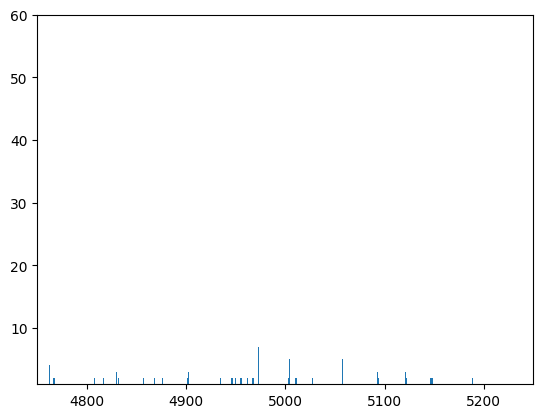

CYC1 - pelm - UL-EN	Len: 10001	Counts: 184	n_cells: 93


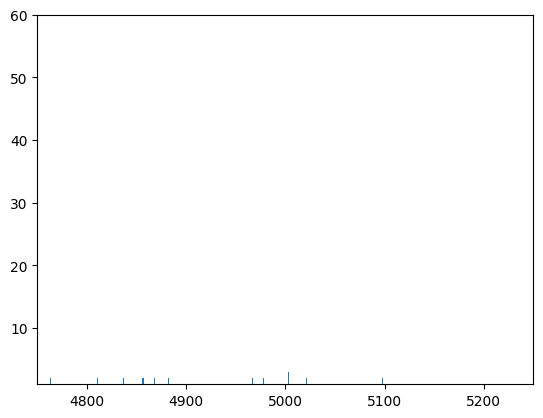

CYC1 - zoxy - Glia	Len: 10001	Counts: 52	n_cells: 26


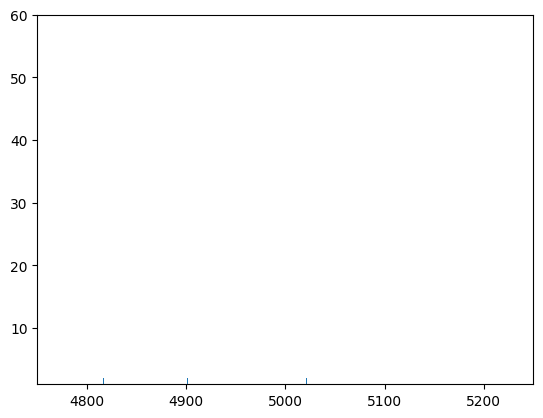

Region: CYC1, donor: zoxy, cell type: UL-EN --> No fragments found
RPL13 - pelm - Glia	Len: 10001	Counts: 158	n_cells: 79


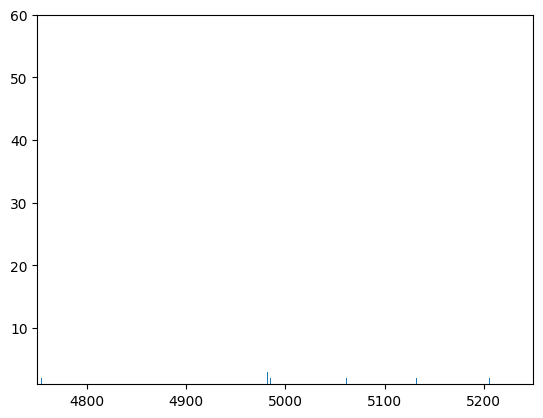

RPL13 - pelm - UL-EN	Len: 10001	Counts: 56	n_cells: 28


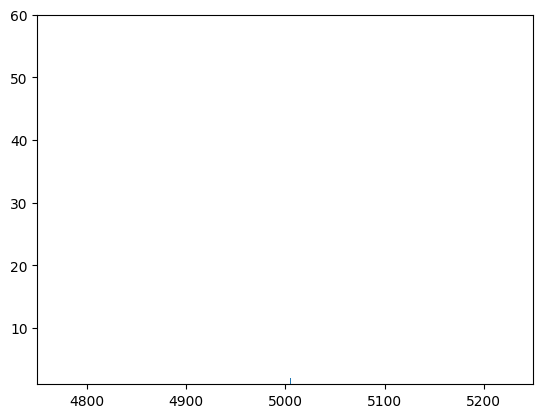

RPL13 - zoxy - Glia	Len: 10001	Counts: 10	n_cells: 5


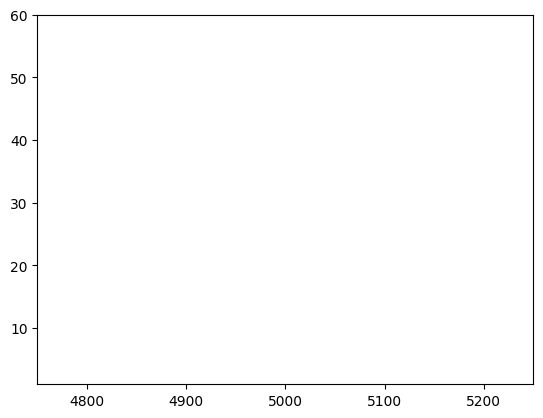

Region: RPL13, donor: zoxy, cell type: UL-EN --> No fragments found
MEF2C - pelm - Glia	Len: 10001	Counts: 11	n_cells: 6


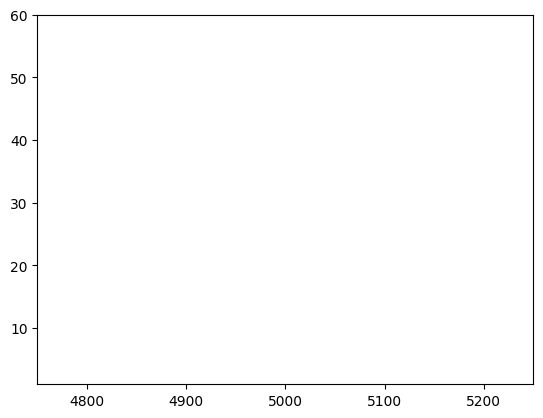

MEF2C - pelm - UL-EN	Len: 10001	Counts: 2	n_cells: 1


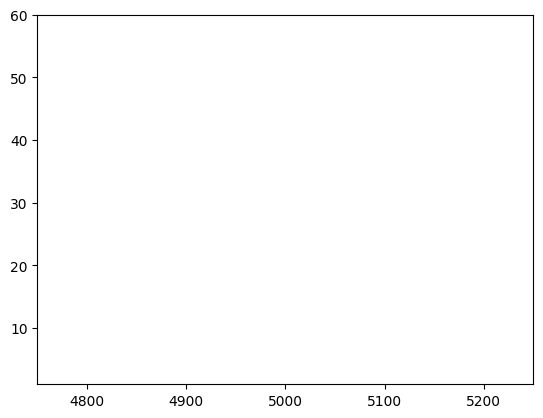

Region: MEF2C, donor: zoxy, cell type: Glia --> No fragments found
Region: MEF2C, donor: zoxy, cell type: UL-EN --> No fragments found
SOX2 - pelm - Glia	Len: 10001	Counts: 688	n_cells: 345


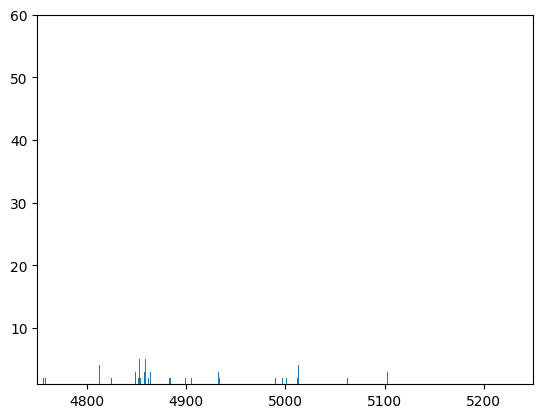

SOX2 - pelm - UL-EN	Len: 10001	Counts: 85	n_cells: 43


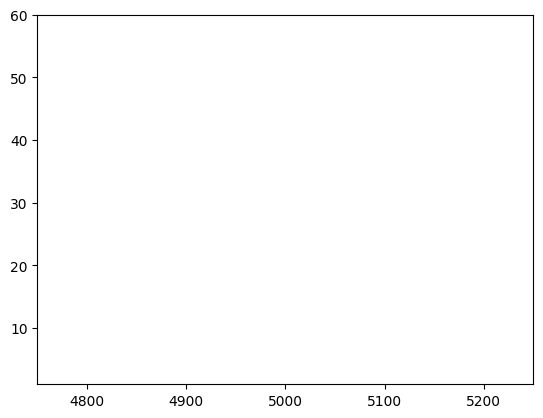

SOX2 - zoxy - Glia	Len: 10001	Counts: 70	n_cells: 35


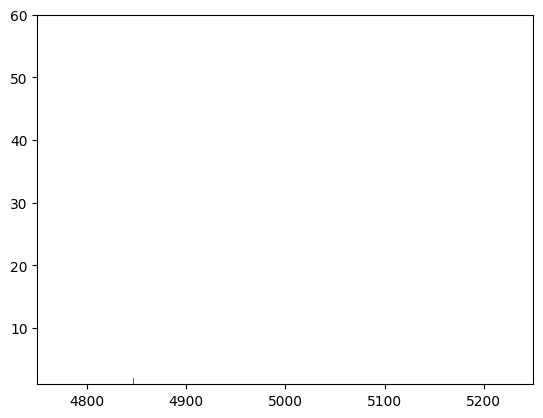

Region: SOX2, donor: zoxy, cell type: UL-EN --> No fragments found
LHX5 - pelm - Glia	Len: 10001	Counts: 42	n_cells: 21


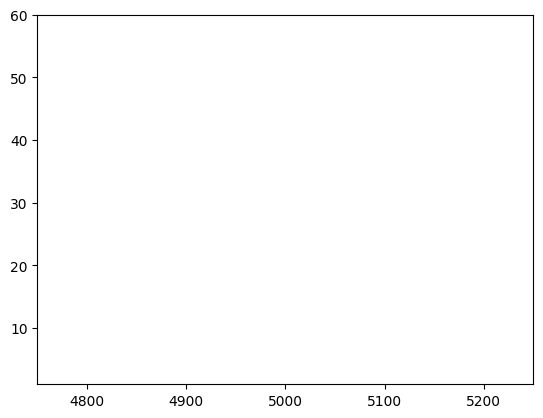

LHX5 - pelm - UL-EN	Len: 10001	Counts: 78	n_cells: 39


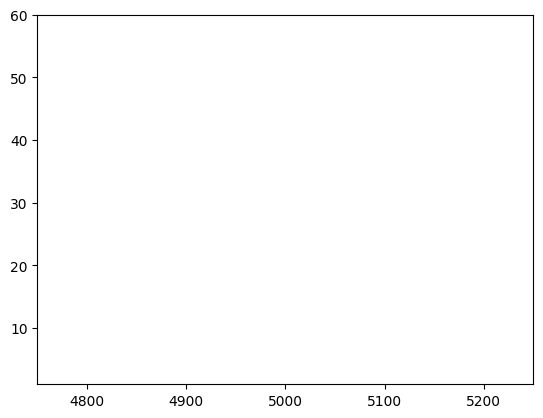

LHX5 - zoxy - Glia	Len: 10001	Counts: 11	n_cells: 6


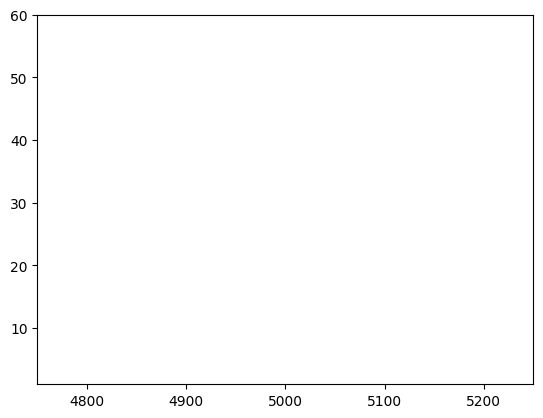

Region: LHX5, donor: zoxy, cell type: UL-EN --> No fragments found


In [21]:
for r in profiles_subset.keys():
    
    for d in q_donors:
        
        for ct in q_ct:
    
            if profiles_subset[r][d][ct]:
                print(f'{r} - {d} - {ct}\tLen: {len(profiles_subset[r][d][ct]["profile"])}\tCounts: {int(sum(profiles_subset[r][d][ct]["profile"]))}\tn_cells: {profiles_subset[r][d][ct]["n_cells"]}') 
                plt.bar(np.linspace(1, len(profiles_subset[r][d][ct]['profile']), len(profiles_subset[r][d][ct]['profile'])), profiles_subset[r][d][ct]['profile'])
                plt.xlim([4750,5250])
                plt.ylim([1,60])
                plt.show()
            else:
                print(f'Region: {r}, donor: {d}, cell type: {ct} --> No fragments found')

In [63]:
frags = profiles['MEF2C']

if min(frags['start'] - regions['MEF2C'][1]) >= 0:
    
    frags['start_0'] = regions['MEF2C'][1]
    frags['end_0'] = regions['MEF2C'][2]
    
    insertions = np.ones(len(frags)*2)
    row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
    col_indices = np.concatenate([np.array(frags.index.tolist()), np.array(frags.index.tolist())])
    
    profile_sm = csr_matrix((insertions, (row_indices, col_indices)), shape = [max(row_indices) + 1, len(frags)])
    profile_sm = profile_sm[0: regions['MEF2C'][2] - regions['MEF2C'][1] + 1]
    
else:
    
    frags['start_0'] = frags['start'] - min(frags['start'])
    frags['end_0'] = frags['end'] - min(frags['start'])
    
    insertions = np.ones(len(frags)*2)
    row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
    col_indices = np.concatenate([np.array(frags.index.tolist()), np.array(frags.index.tolist())])
    
    profile_sm = csr_matrix((insertions, (row_indices, col_indices)), shape = [max(row_indices) + 1, len(frags)])
    profile_sm = profile_sm[regions['MEF2C'][1] - min(frags['start']) : regions['MEF2C'][2] - min(frags['start']) + 1]

In [1]:
profile = profile_sm.sum(axis=1).tolist()
profile = [j for i in profile for j in i]
print(f'W/O Counts: {int(sum(profile))}\nLen: {len(profile)}')

NameError: name 'profile_sm' is not defined

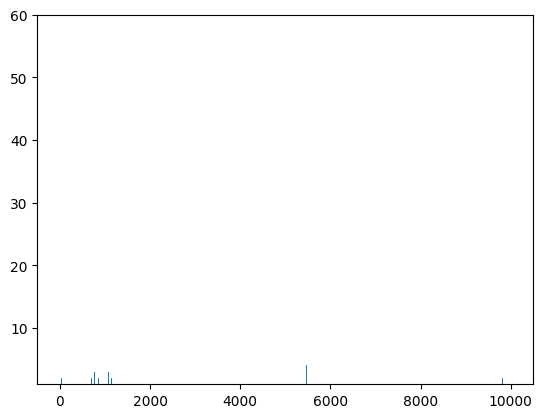

In [65]:
plt.bar(np.linspace(1, len(profile), len(profile)), profile)
# plt.xlim([0,300])
plt.ylim([1,60])
plt.show()

In [ ]:
plt.bar(np.linspace(1, len(profile), len(profile)), profile)
plt.xlim([6000,7000])
plt.ylim([1,60])
plt.show()

In [ ]:
frags = profiles['SOX2']

if min(frags['start'] - regions[0][2]) >= 0:
    
    frags['start_0'] = regions[0][2]
    frags['end_0'] = regions[0][3]
    
    insertions = np.ones(len(frags)*2)
    row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
    col_indices = np.concatenate([np.array(frags.index.tolist()), np.array(frags.index.tolist())])
    
    profile_sm = csr_matrix((insertions, (row_indices, col_indices)), shape = [max(row_indices) + 1, len(frags)])
    profile_sm = profile_sm[0: regions[0][3] - regions[0][2] + 1]
    
else:
    
    frags['start_0'] = frags['start'] - min(frags['start'])
    frags['end_0'] = frags['end'] - min(frags['start'])
    
    insertions = np.ones(len(frags)*2)
    row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
    col_indices = np.concatenate([np.array(frags.index.tolist()), np.array(frags.index.tolist())])
    
    profile_sm = csr_matrix((insertions, (row_indices, col_indices)), shape = [max(row_indices) + 1, len(frags)])
    profile_sm = profile_sm[regions[0][2] - min(frags['start']) : regions[0][3] - min(frags['start']) + 1]

In [ ]:
profile = profile_sm.sum(axis=1).tolist()
profile = [j for i in profile for j in i]
print(f'Counts: {int(sum(profile))}\nLen: {len(profile)}')

In [ ]:
plt.bar(np.linspace(1, len(profile), len(profile)), profile)
# plt.xlim([4800,5300])
plt.ylim([1,60])
plt.show()

In [ ]:
# import pandas
# import os
# import requests
# from tqdm import tqdm
# from pathlib import Path

# x = pandas.read_csv(OUT_FILE, sep='\t', header=None)

# x

# --- below Chatgpt ---
# Download the hg38 genome assembly

# hg38_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz'
# hg38_path = "data/genome/hg38.fa.gz"

# if not os.path.isdir('data/genome'):
#     Path('data/genome').mkdir(parents=True, exist_ok=True)

# def download_file(url, output_file):
#     response = requests.get(url, stream=True)
#     response.raise_for_status()  # Check for request errors

#     # Download the file in chunks to avoid memory issues with large files
#     with open(output_file, "wb") as file:
#         for chunk in response.iter_content(chunk_size=8192):
#             file.write(chunk)

#     print(f'Downloaded {output_file}')

# download_file(hg38_url, hg38_path)